epoch: initial, loss: 2.3636390898/2.36419412254 accuracy: 0.0888166666667/0.0888
....................
epoch: 1, loss: 1.92725270421/1.92829992427 accuracy: 0.715033333333/0.7075
....................
epoch: 2, loss: 1.7427773999/1.74052244741 accuracy: 0.801483333333/0.8025
....................
epoch: 3, loss: 1.64441840235/1.64323781534 accuracy: 0.88295/0.8816
....................
epoch: 4, loss: 1.61025984146/1.61057674996 accuracy: 0.903733333333/0.8994
....................
epoch: 5, loss: 1.59061815899/1.59223122078 accuracy: 0.916333333333/0.9101
....................
epoch: 6, loss: 1.57759444952/1.58035841192 accuracy: 0.924483333333/0.9162
....................
epoch: 7, loss: 1.56775405465/1.57164836579 accuracy: 0.93115/0.9203
....................
epoch: 8, loss: 1.56003996561/1.56495551731 accuracy: 0.936166666667/0.9246
....................
epoch: 9, loss: 1.55370964164/1.55958307858 accuracy: 0.9403/0.9285
....................
epoch: 10, loss: 1.5483820976/1.55493738044 acc

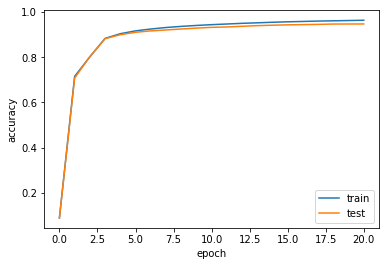

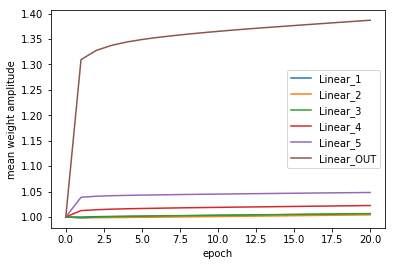

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import gzip
import os
import cPickle as pickle
import urllib


# ---------------------------------------
# -------------- DATASETS ---------------
# ---------------------------------------
def load_XOR():
    """
    Loads training data for XOR function. The outputs are encoded using one-hot encoding, so you can check softmax and
    cross-entropy loss function.
    :return: Pair of numpy arrays: (4, 2) training inputs and (4, 2) training labels
    """
    X = np.asarray([
        [0.0, 0.0],
        [0.0, 1.0],
        [1.0, 0.0],
        [1.0, 1.0]], dtype=np.float32)
    T = np.asarray([
        [0.0, 1.0],
        [1.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0]], dtype=np.float32)
    return X, T


def load_spirals():
    '''
    Loads training and testing data of the spiral dataset. The inputs are standardized and the output labels are one-hot encoded.
    Source based on http://cs231n.github.io/
    :return: Quadruple of numpy arrays (100, 2) training inputs, (100, 3) one-hot encoded training labels,
        (100, 2) testing inputs and (100, 3) one-hot encoded testing labels
    '''

    def generate_points(N):
        K = 3
        X = np.zeros((N * K, 2), dtype=np.float32)
        T = np.zeros((N * K, K), dtype=np.float32)
        for i in xrange(K):
            r = np.linspace(0.0, 2.5, N)
            t = np.linspace(i * 4, (i + 1) * 4, N) + rng.randn(N) * 0.2
            ix = range(N * i, N * (i + 1))
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            T[ix, i] = 1.0  # one-hot encoding
        return X, T

    rng = np.random.RandomState(1234)
    X_train, T_train = generate_points(100)
    X_test, T_test = generate_points(100)
    return X_train, T_train, X_test, T_test


def plot_2D_classification(X, T, net):
    """
    Plots a classification for 2D inputs. The call of this function should be followed by plt.show()
    in non-interactive matplotlib session.
    :param X: Input of shape (n_samples, 2)
    :param T: One-hot encoded target labels of shape (n_samples, n_classes)
    :param net: trained network, instance of MLP class
    """
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = net.propagate(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(T, axis=1), s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def load_MNIST():
    """
    Loads MNIST dataset. If not present locally, the dataset is downloaded from Yann LeCun's site.
    The dataset consists of 60k training and 10k testing samples of 28x28 grayscale images. The inputs are standardized
    and the output labels are one-hot encoded.
    Inspired by https://gist.github.com/ischlag/41d15424e7989b936c1609b53edd1390
    :return: Quadruple of numpy arrays (60000, 784) training inputs, (60000, 10) one-hot encoded training labels,
        (10000, 784) testing inputs and (10000, 10) one-hot encoded testing labels
    """
    IMAGE_SIZE = 28
    N_CLASSES = 10
    files = {
        'X_train': ('train-images-idx3-ubyte.gz', 60000),
        'T_train': ('train-labels-idx1-ubyte.gz', 60000),
        'X_test': ('t10k-images-idx3-ubyte.gz', 10000),
        'T_test': ('t10k-labels-idx1-ubyte.gz', 10000),
    }
    data = {}
    for label, (name, n_images) in files.iteritems():
        if not os.path.exists(name):
            print('downloading: {}'.format(name))
            urllib.urlretrieve('http://yann.lecun.com/exdb/mnist/{}'.format(name), name)
        with gzip.open(name) as bytestream:
            if label.startswith('X'):

                bytestream.read(16)  # header
                data[label] = (np.frombuffer(bytestream.read(IMAGE_SIZE * IMAGE_SIZE * n_images),
                                             dtype=np.uint8).astype(np.float32) / 255.0).reshape(n_images, -1)
            else:
                bytestream.read(8)  # header
                classes = np.frombuffer(bytestream.read(n_images), dtype=np.uint8).astype(np.int64)
                onehot = np.zeros((len(classes), N_CLASSES), dtype=np.float32)
                onehot[np.arange(len(classes)), classes] = 1
                data[label] = onehot

    # standardization
    X_train, T_train, X_test, T_test = [data[label] for label in ['X_train', 'T_train', 'X_test', 'T_test']]
    m, s = X_train.mean(axis=0), X_train.std(axis=0)
    mask = s > 0.0
    X_train[:, mask] = (X_train[:, mask] - m[mask]) / s[mask]
    X_test[:, mask] = (X_test[:, mask] - m[mask]) / s[mask]

    return X_train, T_train, X_test, T_test


def plot_MNIST(array, n_cols=10):
    """
    Plots table of MNIST characters with defined number of columns. The number of characters divided by the number of
    columns, i.e. the number of rows, must be integer. The call of this function should be followed by plt.show()
    in non-interactive matplotlib session.
    session.
    :param array: input array of shape (number of characters, 784)
    :param n_cols: number of table columns
    """
    n, height, width = array.shape[0], 28, 28
    n_rows = n // n_cols
    assert n == n_rows * n_cols, [n, n_rows * n_cols]
    result = (array.reshape(n_rows, n_cols, height, width)
              .swapaxes(1, 2)
              .reshape(height * n_rows, width * n_cols))
    plt.imshow(result, cmap='gray')


# ---------------------------------------
# -------------- LAYERS -----------------
# ---------------------------------------

class LinearLayer(object):
    def __init__(self, n_inputs, n_units, rng, name):
        """
        Linear (dense, fully-connected) layer.
        :param n_inputs:
        :param n_units:
        :param rng: random number generator used for initialization
        :param name:
        """
        super(LinearLayer, self).__init__()
        self.n_inputs = n_inputs
        self.n_units = n_units
        self.rng = rng
        self.name = name
        self.initialize()

    def has_params(self):
        return True

    def forward(self, X):
        """
        Forward message.
        :param X: layer inputs, shape (n_samples, n_inputs)
        :return: layer output, shape (n_samples, n_units)
        """
        n_samples = X.shape[0]
        Y = X.dot(self.W) + self.b
        Y.shape[0] == n_samples
        Y.shape[1] == self.n_units
        return Y

    def delta(self, Y, delta_next):
        """
        Computes delta (dl/d(layer inputs)), based on delta from the following layer. The computations involve backward
        message.
        :param Y: output of this layer (i.e., input of the next), shape (n_samples, n_units)
        :param delta_next: delta vector backpropagated from the following ayer, shape (n_samples, n_units)
        :return: delta vector from this layer, shape (n_samples, n_inputs)
        """
        n_samples = delta_next.shape[0]
        delta = delta_next.dot(self.W.T)
        delta.shape[0] == n_samples
        delta.shape[1] == self.n_inputs
        return delta

    def grad(self, X, delta_next):
        """
        Gradient averaged over all samples. The computations involve parameter message.
        :param X: layer input, shape (n_samples, n_inputs)
        :param delta_next: delta vector backpropagated from the following layer, shape (n_samples, n_units)
        :return: a list of two arrays [dW, db] corresponding to gradients of loss w.r.t. weights and biases, the shapes
        of dW and db are the same as the shapes of the actual parameters (self.W, self.b)
        """
        n_samples = X.shape[0]
        dW = X.T.dot(delta_next) / n_samples
        db = delta_next.sum(0) / n_samples
        dW.shape == self.W.shape
        db.shape == self.b.shape
        return [dW,db]

    def initialize(self):
        """
        Perform He's initialization (https://arxiv.org/pdf/1502.01852.pdf). This method is tuned for ReLU activation
        function. Biases are initialized to 1 increasing probability that ReLU is not initially turned off.
        """
        scale = np.sqrt(2.0 / self.n_inputs)
        self.W = self.rng.normal(loc=0.0, scale=scale, size=(self.n_inputs, self.n_units))
        self.b = np.ones(self.n_units)

    def update_params(self, dtheta):
        """
        Updates weighs and biases.
        :param dtheta: contains a two element list of weight and bias updates the shapes of which corresponds to self.W
        and self.b
        """
        len(dtheta) == 2, len(dtheta)
        dW, db = dtheta
        dW.shape == self.W.shape, dW.shape
        db.shape == self.b.shape, db.shape
        self.W += dW
        self.b += db


class ReLULayer(object):
    def __init__(self, name):
        super(ReLULayer, self).__init__()
        self.name = name

    def has_params(self):
        return False

    def forward(self, X):
        n_samples = X.shape[0]
        n_units = X.shape[1]
        Y = np.maximum(X, 0);
        Y.shape[0] == n_samples
        Y.shape[1] == n_units
        return Y

    def delta(self, Y, delta_next):
        n_samples = delta_next.shape[0]
        n_units = delta_next.shape[1]

        delta = np.zeros(delta_next.shape)
        delta[Y > 0] = delta_next[Y > 0];

        delta.shape[0] == n_samples
        delta.shape[1] == n_units
        return delta


class SoftmaxLayer(object):
    def __init__(self, name):
        super(SoftmaxLayer, self).__init__()
        self.name = name

    def has_params(self):
        return False

    def forward(self, X):
        n_samples = X.shape[0]
        n_units = X.shape[1]

        Xe = np.exp(X - np.max(X,1).reshape((n_samples,1)))
        sms = Xe.sum(1).reshape((n_samples,1))

        Y = Xe / sms

        Y.shape[0] == n_samples
        Y.shape[1] == n_units
        return Y


    def delta(self, Y, delta_next):
        n_samples = delta_next.shape[0]
        n_units = delta_next.shape[1]

        delta = np.zeros([n_samples,n_units])

        for n in xrange(n_samples):
            z2 = Y[n,:]
            d = delta_next[n,:]
            mat = np.tile(d,(n_units,1)) * (np.diag(z2) - z2.reshape((n_units,1)).dot(z2.reshape((1,n_units))) )
            dta = np.sum(mat,1).reshape((1,n_units))

            delta[n,:] = dta

        delta.shape[0] == n_samples
        delta.shape[1] == n_units
        return delta



class LossCrossEntropy(object):
    def __init__(self, name):
        super(LossCrossEntropy, self).__init__()
        self.name = name

    def forward(self, X, T):
        """
        Forward message.
        :param X: loss inputs (outputs of the previous layer), shape (n_samples, n_inputs), n_inputs is the same as
        the number of classes
        :param T: one-hot encoded targets, shape (n_samples, n_inputs)
        :return: layer output, shape (n_samples, 1)
        """
        n_samples = X.shape[0]

        Y = -np.log(X[T == 1]).reshape((n_samples,1))

        Y.shape[0] == n_samples
        Y.shape[1] == 1
        return Y


    def delta(self, X, T):
        """
        Computes delta vector for the output layer.
        :param X: loss inputs (outputs of the previous layer), shape (n_samples, n_inputs), n_inputs is the same as
        the number of classes
        :param T: one-hot encoded targets, shape (n_samples, n_inputs)
        :return: delta vector from the loss layer, shape (n_samples, n_inputs)
        """
        n_samples = X.shape[0]
        n_inputs = X.shape[1]

        delta = -T / X

        delta.shape[0] == n_samples
        delta.shape[1] == n_inputs
        return delta



class LossCrossEntropyForSoftmaxLogits(object):
    def __init__(self, name):
        super(LossCrossEntropyForSoftmaxLogits, self).__init__()
        self.name = name

    def forward(self, X, T):
        n_samples = X.shape[0]
        n_inputs = X.shape[1]

        LogSumXe = np.log(np.exp(X).sum(1)).reshape((n_samples,1))
        sk = X[T == 1].reshape((n_samples,1))
        Y = -sk + LogSumXe

        Y.shape[0] == n_samples
        Y.shape[1] == 1
        return Y


    def delta(self, X, T):

        n_samples = X.shape[0]
        n_inputs = X.shape[1]

        Xe = np.exp(X - np.max(X,1).reshape((n_samples,1)))
        sms = Xe.sum(1).reshape((n_samples,1))
        P = Xe / sms

        delta = P - T

        delta.shape[0] == n_samples
        delta.shape[1] == n_inputs
        return delta


# ---------------------------------------
# -------------- MLP --------------------
# ---------------------------------------

class MLP(object):
    def __init__(self, n_inputs, layers, loss, output_layers=[]):
        """
        MLP constructor.
        :param n_inputs:
        :param layers: list of layers
        :param loss: loss function layer
        :param output_layers: list of layers appended to "layers" in evaluation phase, parameters of these are not used
        in training phase
        """
        self.n_inputs = n_inputs
        self.layers = layers
        self.output_layers = output_layers
        self.loss = loss
        self.first_param_layer = layers[-1]
        for l in layers:
            if l.has_params():
                self.first_param_layer = l
                break

    def propagate(self, X, output_layers=True, last_layer=None):
        """
        Feedforward network propagation
        :param X: input data, shape (n_samples, n_inputs)
        :param output_layers: controls whether the self.output_layers are appended to the self.layers in evaluatin
        :param last_layer: if not None, the propagation will stop at layer with this name
        :return: propagated inputs, shape (n_samples, n_units_of_the_last_layer)
        """
        layers = self.layers + (self.output_layers if output_layers else [])
        if last_layer is not None:
            assert isinstance(last_layer, basestring)
            layer_names = map(lambda layer: layer.name, layers)
            layers = layers[0: layer_names.index(last_layer) + 1]
        for layer in layers:
            X = layer.forward(X)

        return X

    def evaluate(self, X, T):
        """
        Computes loss.
        :param X: input data, shape (n_samples, n_inputs)
        :param T: target labels, shape (n_samples, n_outputs)
        :return:
        """
        return self.loss.forward(self.propagate(X, output_layers=False), T)

    def gradient(self, X, T):
        """
        Computes gradient of loss w.r.t. all network parameters.
        :param X: input data, shape (n_samples, n_inputs)
        :param T: target labels, shape (n_samples, n_outputs)
        :return: a dict of records in which key is the layer.name and value the output of grad function
        """

        Ya = {} # save output of each layer
        Xa = {} # save input of each layer

        for layer in self.layers: # get inputs & outputs of each layer
            Xa[layer.name] = X
            X = layer.forward(X)
            Ya[layer.name] = X

        delta = self.loss.delta(X,T)

        G = {}
        for layer in reversed(self.layers): # get gradients
            if layer.has_params():
                G[layer.name] = layer.grad(Xa[layer.name], delta)
            delta = layer.delta(Ya[layer.name],delta) # propragate deltas

        return G


# ---------------------------------------
# -------------- TRAINING ---------------
# ---------------------------------------

def accuracy(Y, T):
    p = np.argmax(Y, axis=1)
    t = np.argmax(T, axis=1)
    return np.mean(p == t)


def train(net, X_train, T_train, batch_size=1, n_epochs=2, eta=0.1, X_test=None, T_test=None, verbose=False):
    """
    Trains a network using vanilla gradient descent.
    :param net:
    :param X_train:
    :param T_train:
    :param batch_size:
    :param n_epochs:
    :param eta: learning rate
    :param X_test:
    :param T_test:
    :param verbose: prints evaluation for each epoch if True
    :return:
    """
    n_samples = X_train.shape[0]
    assert T_train.shape[0] == n_samples
    assert batch_size <= n_samples
    run_info = defaultdict(list)

    def process_info(epoch):
        loss_test, acc_test = np.nan, np.nan
        Y = net.propagate(X_train)
        loss_train = net.loss.forward(Y, T_train)
        acc_train = accuracy(Y, T_train)
        run_info['loss_train'].append(loss_train)
        run_info['acc_train'].append(acc_train)
        if X_test is not None:
            Y = net.propagate(X_test)
            loss_test = net.loss.forward(Y, T_test)
            acc_test = accuracy(Y, T_test)
            run_info['loss_test'].append(loss_test)
            run_info['acc_test'].append(acc_test)
        if verbose:
            print('epoch: {}, loss: {}/{} accuracy: {}/{}'.format(epoch, np.mean(loss_train), np.nanmean(loss_test),
                                                                  np.nanmean(acc_train), np.nanmean(acc_test)))
        for layer in net.layers:
            if(layer.has_params()): # only for linear layers
                mn = np.mean(np.abs(layer.W))
                run_info[layer.name].append(mn)

    process_info('initial')
    for epoch in xrange(1, n_epochs + 1):
        offset = 0
        while offset < n_samples:
            last = min(offset + batch_size, n_samples)
            if verbose:
                print('.', end='')
            grads = net.gradient(np.asarray(X_train[offset:last]), np.asarray(T_train[offset:last]))
            for layer in net.layers:
                if layer.has_params():
                    gs = grads[layer.name]
                    dtheta = map(lambda g: -eta * g, gs)
                    layer.update_params(dtheta)

            offset += batch_size
        if verbose:
            print()
        process_info(epoch)
    return run_info


# ---------------------------------------
# -------------- EXPERIMENTS ------------
# ---------------------------------------

def plot_convergence(run_info):
    plt.plot(run_info['acc_train'], label='train')
    plt.plot(run_info['acc_test'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()


def plot_test_accuracy_comparison(run_info_dict):
    keys = sorted(run_info_dict.keys())
    for key in keys:
        plt.plot(run_info_dict[key]['acc_test'], label=key)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

def plot_mean_weights(run_info,layers):
    for key in layers:
        plt.plot(run_info[key]/run_info[key][0], label=key)
    plt.xlabel('epoch')
    plt.ylabel('mean weight amplitude')
    plt.legend()


def experiment_XOR():
    X, T = load_XOR()
    rng = np.random.RandomState(1234)
    net = MLP(n_inputs=2,
              layers=[
                  LinearLayer(n_inputs=2, n_units=4, rng=rng, name='Linear_1'),
                  ReLULayer(name='ReLU_1'),
                  LinearLayer(n_inputs=4, n_units=2, rng=rng, name='Linear_OUT'),
                  SoftmaxLayer(name='Softmax_OUT')
              ],
              loss=LossCrossEntropy(name='CE'),
              )

    run_info = train(net, X, T, batch_size=4, eta=0.1, n_epochs=100, verbose=True)
    plot_convergence(run_info)
    plt.show()
    print(net.propagate(X))
    plot_2D_classification(X, T, net)
    plt.show()
    plot_mean_weights(run_info, ['Linear_1','Linear_OUT'])
    plt.show()


def experiment_spirals():
    X_train, T_train, X_test, T_test = load_spirals()
    experiments = (
        ('eta = 0.2', 0.2),
        ('eta = 1', 1.0),
        ('eta = 5', 5.0),
    )
    run_info_dict = {}
    for name, eta in experiments:
        rng = np.random.RandomState(1234)
        net = MLP(n_inputs=2,
                  layers=[
                      LinearLayer(n_inputs=2, n_units=10, rng=rng, name='Linear_1'),
                      ReLULayer(name='ReLU_1'),
                      LinearLayer(n_inputs=10, n_units=3, rng=rng, name='Linear_OUT'),
                      SoftmaxLayer(name='Softmax_OUT')
                  ],
                  loss=LossCrossEntropy(name='CE'),
                  )

        run_info = train(net, X_train, T_train, batch_size=len(X_train), eta=eta, X_test=X_test, T_test=T_test,
                         n_epochs=1000, verbose=True)
        run_info_dict[name] = run_info
        # plot_spirals(X_train, T_train, net)
        # plt.show()
        # plot_convergence(run_info)
        # plt.show()
    plot_test_accuracy_comparison(run_info_dict)
    plt.show()
    # plt.savefig('spiral.pdf') # you can instead save figure to file


def experiment_MNIST():
    X_train, T_train, X_test, T_test = load_MNIST()
    np.seterr(all='raise', under='warn', over='warn')
    rng = np.random.RandomState(1234)
    net = MLP(n_inputs=28 * 28,
              layers=[
                  LinearLayer(n_inputs=28 * 28, n_units=64, rng=rng, name='Linear_1'),
                  ReLULayer(name='ReLU_1'),
                  LinearLayer(n_inputs=64, n_units=64, rng=rng, name='Linear_2'),
                  ReLULayer(name='ReLU_2'),
                  LinearLayer(n_inputs=64, n_units=64, rng=rng, name='Linear_3'),
                  ReLULayer(name='ReLU_3'),
                  LinearLayer(n_inputs=64, n_units=64, rng=rng, name='Linear_4'),
                  ReLULayer(name='ReLU_4'),
                  LinearLayer(n_inputs=64, n_units=64, rng=rng, name='Linear_5'),
                  ReLULayer(name='ReLU_5'),
                  LinearLayer(n_inputs=64, n_units=10, rng=rng, name='Linear_OUT'),
              ],
              loss=LossCrossEntropyForSoftmaxLogits(name='CE'),
              output_layers=[SoftmaxLayer(name='Softmax_OUT')]
              )

    run_info = train(net, X_train, T_train, batch_size=3000, eta=1e-1, X_test=X_test, T_test=T_test, n_epochs=20,
                     verbose=True)
    plot_convergence(run_info)
    plt.show()
    plot_mean_weights(run_info,['Linear_1','Linear_2','Linear_3','Linear_4','Linear_5','Linear_OUT'])
    plt.show()

    #with open('MNIST_run_info.p', 'w') as f:
    #    pickle.dump(run_info, f)


if __name__ == '__main__':
    #experiment_XOR()

    #experiment_spirals()

    experiment_MNIST()

